# А/B-тестирование

## Описание проекта

**Cookie Cats** — это очень популярная мобильная игра-головоломка от Tactile Entertainment. Это классическая игра в жанре «соедини три»: игрок должен совмещать плитки одного цвета, чтобы очистить поле и пройти уровень. А ещё там поют коты. Серьёзно!

По мере прохождения игроки сталкиваются с **гейтами**, которые вынуждают их ждать или совершать внутриигровую покупку для продолжения. В этом проекте мы разберём результаты A/B-теста, где первые гейты были перенесены с 30-го уровня на 40-й. Основной фокус — анализ влияния этого изменения на **player retention** (удержание игроков).

Данные были собраны от 90 189 игроков, установивших игру во время проведения A/B-теста.

### Переменные:
1. **`userid`** - уникальный идентификатор игрока
2. **`version`** - группа тестирования:
      - `gate_30` (контрольная группа) - гейт на 30 уровне
      - `gate_40` (тестовая группа) - гейт на 40 уровне  
3. **`sum_gamerounds`** - количество игровых раундов за первую неделю
4. **`retention_1`** - бинарный показатель возврата через 1 день (1 - вернулся, 0 - нет)
5. **`retention_7`** - бинарный показатель возврата через 7 дней (1 - вернулся, 0 - нет)

### Дизайн эксперимента:
При установке игры игроки случайным образом распределялись в одну из групп:
- Контрольная группа (`gate_30`)
- Тестовая группа (`gate_40`)

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

## Загрузка данных

Рассмотрим подробнее наши данные.

In [77]:
df = pd.read_csv('cookie_cats.csv')

def check_df(dataframe, head=5):
    print('SHAPE'.center(70,'-'))
    print(dataframe.shape)
    print('HEAD'.center(70,'-'))
    print(dataframe.head(head))
    print('INFO'.center(70,'-'))
    print(dataframe.info())
    print('NUNIQUE'.center(70,'-'))
    print(dataframe.nunique())
    print('MISSING VALUES'.center(70,'-'))
    print(dataframe.isnull().sum())
    print('DUPLICATED VALUES'.center(70,'-'))
    print(dataframe.duplicated().sum())
    
    
check_df(df)

--------------------------------SHAPE---------------------------------
(90189, 5)
---------------------------------HEAD---------------------------------
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
---------------------------------INFO---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  b

В данных нет пропусков и повторяющихся значений. Все `userid` уникальны.

In [78]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


При установке игры каждый игрок рандомизированно распределялся в одну из групп. Количество игроков в контрольной и тестовой группах примерно одинаково, что подтверждает корректность проведения рандомизации.

## Анализ поведения игроков

Построим боксплот, чтобы визуализировать распределение переменной `sum_gamerounds`. Это даст нам общее представление о том, сколько игровых раундов в среднем проходили игроки в течение первой недели после установки игры.

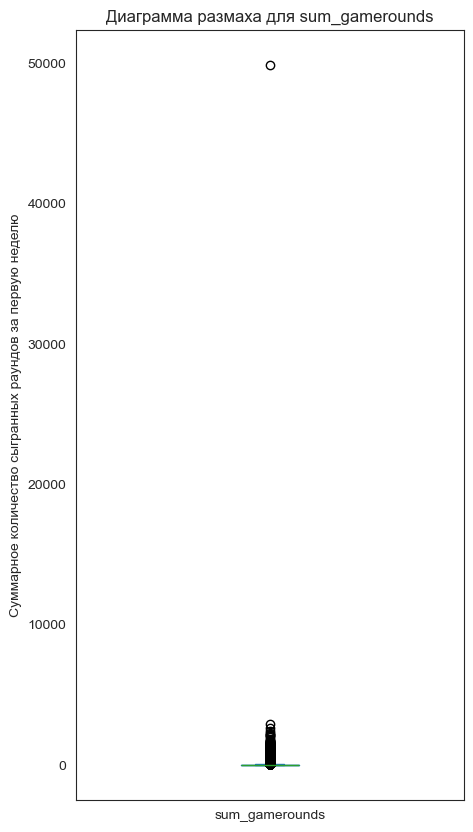

In [79]:
sns.set_style('white')
df['sum_gamerounds'].plot.box(figsize=(5,10))
plt.ylabel('Суммарное количество сыгранных раундов за первую неделю')
plt.title('Диаграмма размаха для sum_gamerounds')
plt.show()

Очевидно, что в данных присутствует выброс — один из игроков сыграл около 50 000 раундов за первую неделю. Из-за этого аномального значения боксплот получается сильно перекошенным и не очень информативным. Чтобы понять поведение основной массы игроков, проанализируем перцентили данных.

In [80]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [81]:
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df.head(10)

sum_gamerounds
0    3994
1    5538
2    4606
3    3958
4    3629
5    2992
6    2861
7    2379
8    2267
9    2013
Name: userid, dtype: int64

Видим, что **50% игроков сыграли менее 16 раундов** в первую неделю после установки и **75% игроков сыграли менее 51 раунда**.

**Около 4 000 игроков не сыграли ни одного раунда** после установки. Возможные причины:
- Могли установить несколько игр одновременно и переключиться на другие.
- Не понравился дизайн, интерфейс или музыка.
- Еще не начали играть (но вероятность низкая, так как данные за первую неделю).

Также отметим, что **более 14 000 игроков сыграли менее 3 раундов**. Причины ухода этих игроков могут быть следующие:
- Игра не понравилась (самая частая причина).
- Игра оказалась не такой, какой её ожидал пользователь.
- Геймплей показался слишком простым и от этого скучным.

Важно понимать, почему большое количество игроков выходят из игры на ранней стадии. Tactile Entertainment может попытаться собрать отзывы игроков, например, с помощью опросов в приложении.

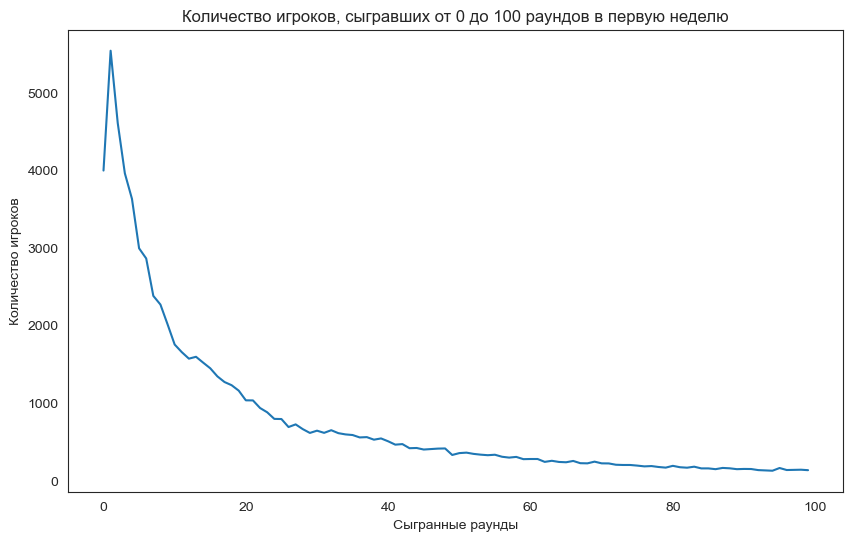

In [82]:
ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title('Количество игроков, сыгравших от 0 до 100 раундов в первую неделю')
ax.set_ylabel('Количество игроков')
ax.set_xlabel('Сыгранные раунды')
plt.show()

Распределение сильно асимметрично, с длинным «хвостом» справа. Огромное количество игроков сыграли менее 20 раундов и вышли из игры. В раундах, где было больше 60 игроков, их количество оставалось стабильным и составляло около 300.

## A/B-тест

**Существует ли статистически значимая разница между общим количеством сыгранных раундов для разных версий игроков (gate_30 и gate_40)?**

**Шаг 1: Определим гипотезы.**

H0: M1 = M2 (Нет статистически значимой разницы между общим количеством сыгранных раундов для разных версий (gate_30 и gate_40))

H1: M1 != M2 (Существует статистически значимая разница между общим количеством сыгранных раундов для разных версий (gate_30 и gate_40))

In [83]:
def ab_test(dataframe, group, control, test, target):
    # Проверяем нормальность распределения
    test_stat, pvalue_control = shapiro(dataframe.loc[dataframe[group] == control, target])
    test_stat, pvalue_test = shapiro(dataframe.loc[dataframe[group] == test, target])

    # Если p-value > 0.05, распределение считается нормальным
    normal_control = pvalue_control > 0.05
    normal_test = pvalue_test > 0.05

    if normal_control and normal_test:
        # Обе группы имеют нормальное распределение, проверяем однородность дисперсий
        test_stat, pvalue_levene = levene(dataframe.loc[dataframe[group] == control, target],
                                  dataframe.loc[dataframe[group] == test, target])
        if pvalue_levene > 0.05:
            # Случай, если дисперсии равны
            test_stat, pvalue = ttest_ind(dataframe.loc[dataframe[group] == control, target],
                                  dataframe.loc[dataframe[group] == test, target], equal_var=True)
        else:
            # Случай, если дисперсии не равны
            test_stat, pvalue = ttest_ind(dataframe.loc[dataframe[group] == control, target],
                                  dataframe.loc[dataframe[group] == test, target], equal_var=False)
            print('Дисперсии не равны, использован t-критерий Уэлча')
    else:
        # Непараметрический статистический критерий (U-критерий Манна — Уитни)
        test_stat, pvalue = mannwhitneyu(dataframe.loc[dataframe[group] == control, target],
                                 dataframe.loc[dataframe[group] == test, target])

    # Интерпретация результатов
    if pvalue > 0.05:
        print(f'Нет статистически значимой разницы в {target} между {control} и {test}')
    else:
        print(f'Существует статистически значимая разница в {target} между {control} and {test}')
    print(f'Статистика критерия = {test_stat: .4f}, p-value = {pvalue: .4f}')


ab_test(df, 'version', 'gate_30', 'gate_40', 'sum_gamerounds')

Нет статистически значимой разницы в sum_gamerounds между gate_30 и gate_40
Статистика критерия =  1024331250.5000, p-value =  0.0502


C:\Users\Mikhail\anaconda3\envs\AB-test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44700.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Mikhail\anaconda3\envs\AB-test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45489.
  res = hypotest_fun_out(*samples, **kwds)


Таким образом, нет статистически значимой разницы между общим количеством сыгранных раундов для разных версий гейтов (gate_30 и gate_40). Давайте посмотрим, есть ли статистически значимая разница между 1-м и 7-м днями удержания для разных уровней гейта.

**Определим гипотезы**.

H0: M1 = M2 (Нет статистически значимой разницы в retention_1 между gate_30 и gate_40)

H1: M1 != M2 (Существует статистически значимая разница в retention_1 между gate_30 и gate_40)

In [84]:
ab_test(df, 'version', 'gate_30', 'gate_40', 'retention_1')

Нет статистически значимой разницы в retention_1 между gate_30 и gate_40
Статистика критерия =  1022682813.0000, p-value =  0.0744


**Определим гипотезы**.

H0: M1 = M2 (Нет статистически значимой разницы в retention_7 между gate_30 и gate_40)

H1: M1 != M2 (Существует статистически значимая разница в retention_7 между gate_30 и gate_40)

In [85]:
ab_test(df, 'version', 'gate_30', 'gate_40', 'retention_7')

Существует статистически значимая разница в retention_7 между gate_30 and gate_40
Статистика критерия =  1025017239.0000, p-value =  0.0016


## Bootstrap-анализ

### Сравнение возврата через один день (1-day Retention)

На представленном выше графике хорошо видно три типа поведения игроков: одни устанавливают игру, но никогда не запускают ее, другие играют всего несколько раундов в первую неделю, а третьи по-настоящему увлекаются игрой. Наша цель — сделать игру максимально захватывающей, чтобы увеличить число увлеченных игроков.

Ключевым показателем в игровой индустрии, отражающим вовлеченность и удовольствие от игры, является 1-day retention — процент игроков, которые возвращаются и играют на следующий день после установки. Этот показатель крайне важен, так как чем выше уровень 1-day retention, тем проще удерживать игроков в долгосрочной перспективе и наращивать игровую аудиторию.

Фактически, 1-day retention служит индикатором первого впечатления от игры. Если игроку понравился геймплей, музыка, интерфейс и общее ощущение от первых минут в игре, вероятность его возвращения значительно возрастает. Именно поэтому разработчики уделяют столько внимания оптимизации начального опыта — эти усилия напрямую влияют на ключевую метрику удержания.

In [86]:
print(f'Показатель 1-day Retention: {df['retention_1'].mean():.4f}')

Показатель 1-day Retention: 0.4452


Менее половины игроков возвращаются в игру на следующий день после установки. Это значение служит важным ориентиром для оценки эффективности изменений в игре. Теперь проанализируем, как показатель 1-day retention различается между контрольной группой (gate_30) и тестовой группой (gate_40).

In [87]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

Наблюдается небольшое, но значимое снижение удержания при переносе гейта на 40 уровень:
- **Контрольная группа (gate_30): 44.8% retention**
- **Тестовая группа (gate_40): 44.2%**

Хотя разница кажется незначительной (всего -0.6 процентных пункта), в масштабах игровой аудитории даже такие изменения могут существенно повлиять на долгосрочную активность игроков.

Чтобы понять, насколько можно доверять этим данным при прогнозировании будущих результатов, мы применим метод бутстрэппинга. Мы будем многократно перебирать наш набор данных с заменой и рассчитывать показатель удержания за 1 день для этих выборок. Разброс показателей удержания за 1 день покажет, насколько неточны эти цифры.

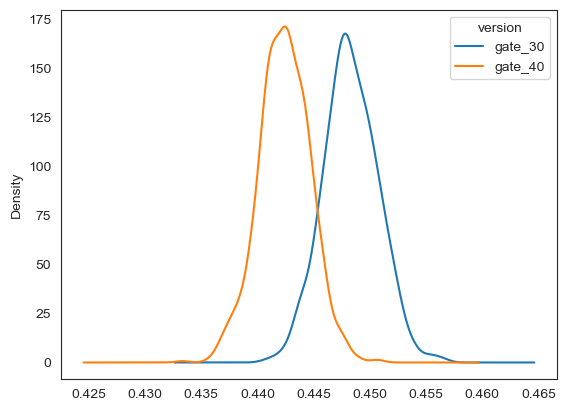

In [88]:
# Создадим список с бутстрэп-выборками для каждой группы
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Создадим датафрейм на основе списка
boot_1d = pd.DataFrame(boot_1d)
    
# Построим графики
boot_1d.plot(kind='density')
plt.show()

Бутстрэп-анализ распределения 1-day retention для двух групп показывает статистически значимую разницу, хотя и незначительную на первый взгляд. Построим график процентной разницы, чтобы рассмотреть её подробнее.

In [89]:
# Добавим колонку diff с разницей в процентах между группами 
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40) / boot_1d.gate_40 * 100

# Визуализируем полученные значения diff
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('Разница в 1-day retention между двумя группами, %')
ax.set_xlabel('Проценты')

# Высчитаем вероятность, что 1-day retention больше, когда гйт на 30 уровне.
print('Вероятность, что 1-day retention больше, когда гейт на 30 уровне:',(boot_1d['diff'] > 0).mean())

Вероятность, что 1-day retention больше, когда гейт на 30 уровне: 0.962


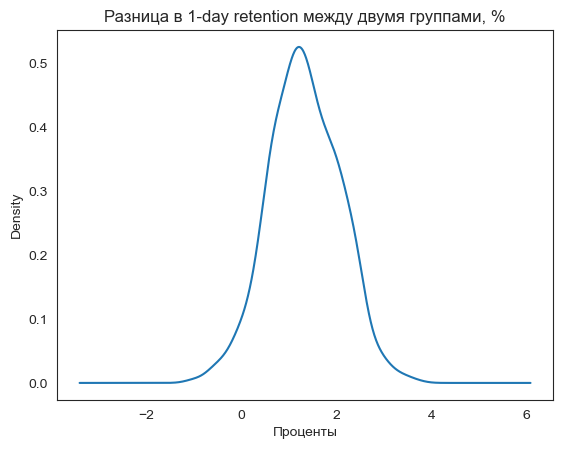

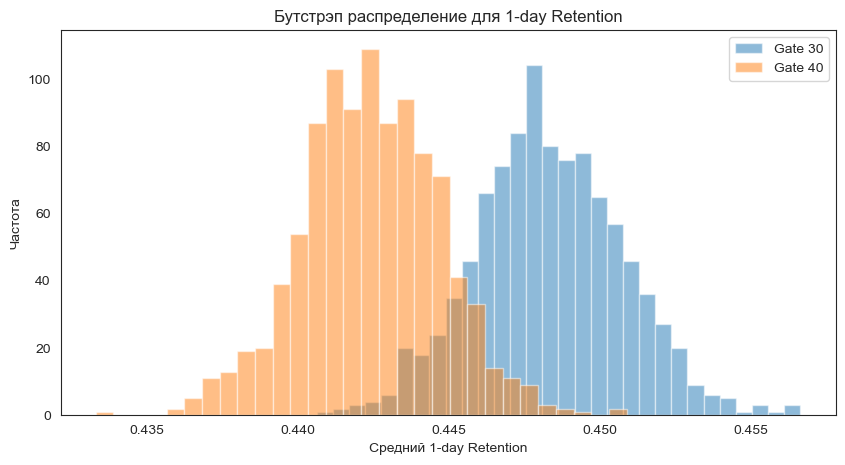

In [90]:
plt.figure(figsize=(10, 5))
plt.hist(boot_1d.gate_30, bins=30, alpha=0.5, label='Gate 30')
plt.hist(boot_1d.gate_40, bins=30, alpha=0.5, label='Gate 40')
plt.title('Бутстрэп распределение для 1-day Retention')
plt.xlabel('Средний 1-day Retention')
plt.ylabel('Частота')
plt.legend()
plt.show()

### Сравнение возврата через семь дней (7-day Retention)

Бутстрэп-анализ действительно показывает высокую вероятность того, что расположение ворот на 30 уровне дает преимущество в 1-day retention. Однако здесь важно учитывать контекст: за первые сутки большинство игроков просто не успевают дойти до 30 уровня. Это означает, что наблюдаемая разница в retention может быть связана не с самим расположением ворот, а с другими факторами, влияющими на первоначальное впечатление от игры.

При переходе к анализу 7-day retention картина становится более показательной. За неделю игрового процесса значительная часть пользователей успевает достичь 40 уровня, поэтому сравнение этого показателя между группами позволит точнее оценить влияние переноса ворот. В этом случае мы сможем измерить эффект непосредственно на тех игроках, которые столкнулись с изменением игровой механики.

In [91]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Ключевые инсайты:
- Как и с 1-day retention, **7-day retention немного ниже, когда гейт находится на 40 уровне (18.2%)**, по сравнению с расположением на 30 уровне (19.0%).
- **Эта разница более выражена, чем для 1-day retention** — вероятно, потому что больше игроков успевают достичь первого гейта за неделю.
- ***Общий показатель 7-day retention ожидаемо ниже, чем 1-day retention**: меньше людей играют через неделю после установки, чем через день.

Как и ранее, применим бутстрэп-анализ, чтобы оценить достоверность разницы между группами A/B-теста.

In [92]:
# Создадим список с бутстрэп-выборками для каждой группы
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Создадим датафрейм на основе списка
boot_7d = pd.DataFrame(boot_7d)

# Добавим колонку diff с разницей в процентах между группами 
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40) / boot_7d.gate_40 * 100

# Визуализируем полученные значения diff
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('Разница в 7-day retention между двумя группами, %')
ax.set_xlabel('Проценты')

# Высчитаем вероятность, что 7-day retention больше, когда гйт на 30 уровне.
print('Вероятность, что 7-day retention больше, когда гейт на 30 уровне:',(boot_7d['diff'] > 0).mean())

Вероятность, что 7-day retention больше, когда гейт на 30 уровне: 1.0


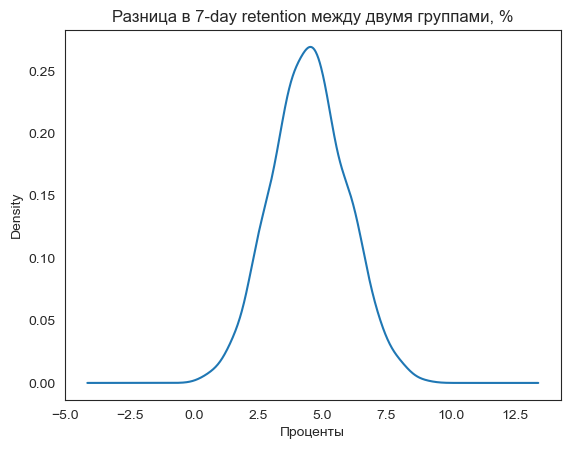

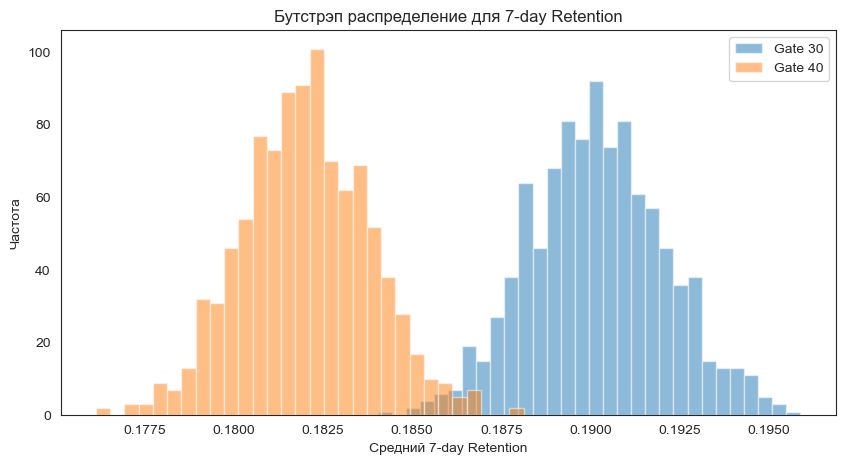

In [93]:
plt.figure(figsize=(10, 5))
plt.hist(boot_7d.gate_30, bins=30, alpha=0.5, label='Gate 30')
plt.hist(boot_7d.gate_40, bins=30, alpha=0.5, label='Gate 40')
plt.title('Бутстрэп распределение для 7-day Retention')
plt.xlabel('Средний 7-day Retention')
plt.ylabel('Частота')
plt.legend()
plt.show()

## Вывод

**Bootstrap и A/B-тестирование — это два метода анализа данных, которые дают разные типы инсайтов. Сравнение их результатов углубляет наше понимание показателей 1-day и 7-day retention между группами gate_30 и gate_40.**

**Результаты A/B-теста**:

- Для **1-day retention** разница между M1 (gate_30) и M2 (gate_40) **не статистически значима** (p-value = 0,0744). Это означает, что в краткосрочной перспективе оба варианта работают одинаково.

- Для **7-day retention** A/B-тест выявил **статистически значимую разницу** (p-value = 0,0016). Версия **gate_30 демонстрирует более высокое долгосрочное удержание**, чем gate_40.

**Результаты Bootstrap-анализа:**

- **1-day retention**: gate_30 имеет более высокий показатель, чем gate_40, с вероятностью **97,0%**.

- **7-day retention**: gate_30 превосходит gate_40 с вероятностью **99,9%**.
Эти данные указывают, что gate_30 эффективнее **удерживает пользователей в игре дольше**, чем gate_40.


**Сравнительный комментарий**:

- **Краткосрочное удержание (1-day retention)**:
Хотя A/B-тест не показал значимой разницы, Bootstrap-анализ предполагает небольшое преимущество gate_30. При этом p-value (0,0744) близок к стандартному порогу значимости (0,05), поэтому разница может иметь **практическую важность**.

- **Долгосрочное удержание (7-day retention)**:
Оба метода подтверждают, что **gate_30 значительно лучше** gate_40.

Рекомендации:

- Для улучшения **7-day retention** следует использовать **gate_30**.

- Для **1-day retention** существенной разницы нет, но gate_30 может давать небольшой плюс.

- При принятии решений важно учитывать:

    - пользовательский опыт (UX),

    - геймплей,

    - другие бизнес-метрики (например, конверсию в платежи).